# Converting FITS Files to a hepfile

[Flexible Image Transport System (FITS) files](https://fits.gsfc.nasa.gov/fits_primer.html) are a fast file format commonly used in astronomy to store image and spectra data taken with telescopes. This tutorial will show you how to take multiple fits files and easily and efficiently store them in a single hepfile. This conversion can be especially useful if you have a bunch of FITS data from different telescopes, with different CCDs and therefore different data dimensions, and want to store it in a single file.

## Software Installation and Data Download
Before continuing with the tutorial, we have to install astropy and download some open source FITS files. We first pip install astropy:

In [1]:
!pip install astropy

Now we run some other bash commands to grab a relatively small zip file of fits data on the Eagle Nebula, unzip them, and clean up the directory by removing unnecessary files. This will leave behind three FITS files of images taken at three different wavelengths: 502nm, 656nm, and 673nm. This data is from NOIRLab and you can find information on it [here](https://noirlab.edu/public/products/applications/fitsliberator/datasets/).

In [2]:
# download some "small" public fits images, unzip them, and clean up the directory
# this downloads three fits files from noirlab with observations of the eagle nebula at 3 different wavelengths
!wget 'https://noirlab.edu/public/media/archives/education/zip/edu008.zip'
!unzip -o 'edu008.zip'
!unzip -o '*.zip'
!rm -rf '__MACOSX'
!rm *.zip
!rm *.psd

--2023-06-29 04:22:43--  https://noirlab.edu/public/media/archives/education/zip/edu008.zip
Resolving noirlab.edu (noirlab.edu)... 54.69.148.74, 54.213.236.16, 34.213.137.190
Connecting to noirlab.edu (noirlab.edu)|54.69.148.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34148278 (33M) [application/zip]
Saving to: ‘edu008.zip’

edu008.zip          100%[===================>]  32.57M  14.4MB/s    in 2.3s    

2023-06-29 04:22:46 (14.4 MB/s) - ‘edu008.zip’ saved [34148278/34148278]

Archive:  edu008.zip
  inflating: 502nmos.zip             
  inflating: __MACOSX/._502nmos.zip  
  inflating: eagle_composite.zip     
  inflating: __MACOSX/._eagle_composite.zip  
  inflating: 673nmos.zip             
  inflating: __MACOSX/._673nmos.zip  
  inflating: 656nmos.zip             
  inflating: __MACOSX/._656nmos.zip  
Archive:  eagle_composite.zip
  inflating: eagle.psd               

Archive:  656nmos.zip
  inflating: 656nmos.fits            

Archive:  673nmos.zip


Now we can import astropy along with other software we will need for this tutorial!

In [3]:
# imports
import os, glob
import hepfile as hf
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

## Exploring the FITS File Structure
Now that we have the data downloaded and astropy installed, we can look at the data. First, let's take a look at the info on the different tables in the three FITS files:

In [4]:
# first grab all the fits files in the working directory
fitsfiles = glob.glob(os.path.join(os.getcwd(), '*.fits'))

# let's open the files
fitsdata = []
for f in fitsfiles:
    hdu_list = fits.open(f)
    print(hdu_list.info()) # this shows all the info
    print()
    fitsdata.append(hdu_list)

Filename: /home/nfranz/research/hepfile/docs/examples/example_nb/673nmos.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     289   (1600, 1600)   float32   
  1  673nmos_cvt.tab    1 TableHDU       353   1R x 49C   [D25.17, D25.17, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, A1, E15.7, I12, I12, D25.17, D25.17, A8, A8, I12, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, I12, I12, I12, I12, I12, I12, I12, I12, A48, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7]   
None

Filename: /home/nfranz/research/hepfile/docs/examples/example_nb/502nmos.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     290   (1600, 1600)   float32   
  1  502nmos_cvt.tab    1 TableHDU       353   1R x 49C   [D25.17, D25.17, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, E15.7, A1, E15.7, I12, I12, D25.17, D25.17, A8, A8, I12, E15.7, E15.7, E15.7, 

It looks like each FITS file has both data, stored in the `PrimaryHDU`, and metadata about the observation, sroed in the `TableHDU`. In astropy, we can easily access this data by indexing by the `No.` column, where 0 is the primary data and 1 is the metadata. Once we do that, we can easily plot the data to make sure it looks like we think it should:

      CRVAL1           CRVAL2      CRPIX1 CRPIX2    CD1_1         CD1_2         CD2_1         CD2_2     ... MEANC10  MEANC25  MEANC50  MEANC100 MEANC200 MEANC300 BACKGRND
----------------- ---------------- ------ ------ ------------ ------------- ------------- ------------- ... -------- -------- -------- -------- -------- -------- --------
274.7115229948199 -13.816390682904  386.5  396.0 1.878013e-05 -2.031193e-05 -2.029358e-05 -1.879711e-05 ... 12.11311 12.13334 13.59485 14.88939 12.93392 12.34968 7.897364
      CRVAL1              CRVAL2       CRPIX1 CRPIX2    CD1_1         CD1_2         CD2_1     ... MEANC10  MEANC25  MEANC50  MEANC100 MEANC200 MEANC300 BACKGRND
------------------ ------------------- ------ ------ ------------ ------------- ------------- ... -------- -------- -------- -------- -------- -------- --------
274.71130937176997 -13.816000630103998  386.5  396.0 1.878013e-05 -2.031193e-05 -2.029358e-05 ... 10.52821 10.84973 10.78265 10.71748 9.907546  8.59161 3.285868
    

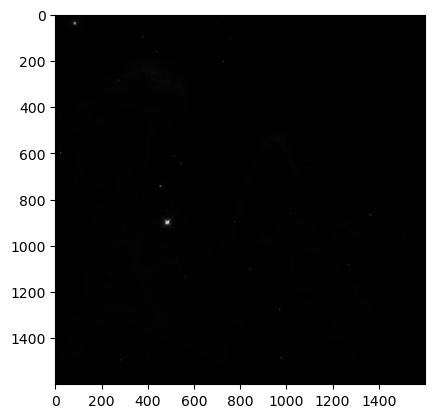

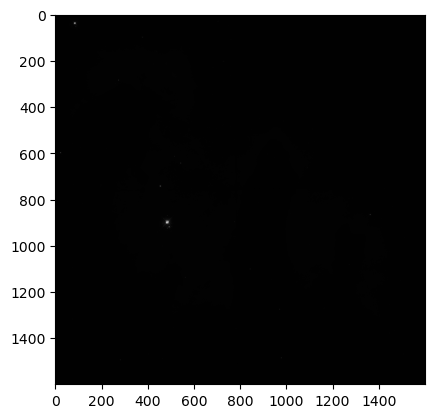

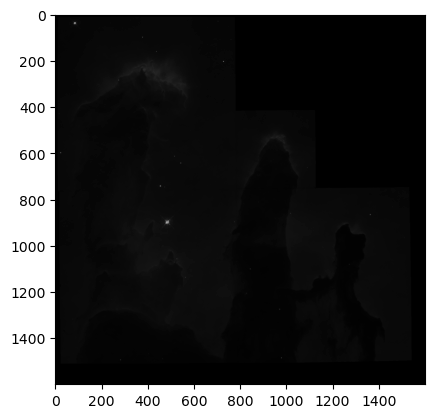

In [5]:
allinfo = []
imgs = []
for d in fitsdata:
    img = np.array(d[0].data)
    info = Table(d[1].data)

    print(info)
    plt.figure()
    plt.imshow(img.T, cmap='Greys_r') # transpose the images to get them upright
    
    allinfo.append(info)
    imgs.append(img)

WOW! We can clearly see stars in the top two images and the gas from the Eagle Nebula in the bottom image. These images don't look as pretty as the images of the Eagle Nebula online but that's because those images have a lot of post processing that go into them! That's not what we're here to do today, instead we want to try to store all of this data in a hepfile!

Finally, we are going to chop out part of the first two images so that we can show that hepfile can store different sized FITS files!

In [ ]:
imgs[0] = imgs[0][:100, :100]
imgs[1] = imgs[1][1000:, 1000:]



## Storing FITS Files in a hepfile
We can think of each of these images as "events" and create a dictionary from them. In this case, the image data is the important data that should be stored in a group while the metadata can easily be stored as singletons. Creating a list of dictionaries of the data will allow us to easily pack the FITS data into a hepfile using the `hepfile.dict_tools` module.

In [6]:
events = []
for img, meta in zip(imgs, allinfo):
    
    event_dict = {}
    for key in meta.keys():
        # these are all the singleton values
        event_dict[key] = meta[key].value[0]
        
    event_dict['data'] = {}
    event_dict['data']['imgs'] = img
    
    events.append(event_dict)

I would show you the events list but it is massively long so it takes up a lot of space in the notebook. Instead, you can imagine that it looks like a larger version of the list from the [Writing Hepfiles From Dictionaries](./writing_hepfiles_from_dicts.ipynb) tutorial. Notice how we can easily store the data as 2D arrays in the hepfile! Now we can store this dictionary in a hepfile using `hepfile.dict_tools.dictlike_to_hepfile`

In [10]:
# put this data in a hepfile
data = hf.dict_tools.dictlike_to_hepfile(events, 'eagle-nebula.h5', how_to_pack='classic', write_hepfile=True)
print(data)

Metadata added
{'_GROUPS_': {'_SINGLETONS_GROUP_': ['COUNTER', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CD1_1', 'CD1_2', 'CD2_1', 'CD2_2', 'DATAMIN', 'DATAMAX', 'MIR_REVR', 'ORIENTAT', 'FILLCNT', 'ERRCNT', 'FPKTTIME', 'LPKTTIME', 'CTYPE1', 'CTYPE2', 'DETECTOR', 'DEZERO', 'BIASEVEN', 'BIASODD', 'GOODMIN', 'GOODMAX', 'DATAMEAN', 'GPIXELS', 'SOFTERRS', 'CALIBDEF', 'STATICD', 'ATODSAT', 'DATALOST', 'BADPIXEL', 'OVERLAP', 'PHOTMODE', 'PHOTFLAM', 'PHOTZPT', 'PHOTPLAM', 'PHOTBW', 'MEDIAN', 'MEDSHADO', 'HISTWIDE', 'SKEWNESS', 'MEANC10', 'MEANC25', 'MEANC50', 'MEANC100', 'MEANC200', 'MEANC300', 'BACKGRND'], 'data': ['ndata', 'imgs']}, '_MAP_DATASETS_TO_COUNTERS_': {'_SINGLETONS_GROUP_': '_SINGLETONS_GROUP_/COUNTER', 'CRVAL1': '_SINGLETONS_GROUP_/COUNTER', 'CRVAL2': '_SINGLETONS_GROUP_/COUNTER', 'CRPIX1': '_SINGLETONS_GROUP_/COUNTER', 'CRPIX2': '_SINGLETONS_GROUP_/COUNTER', 'CD1_1': '_SINGLETONS_GROUP_/COUNTER', 'CD1_2': '_SINGLETONS_GROUP_/COUNTER', 'CD2_1': '_SINGLETONS_GROUP_/COUNTER', 'CD2_2

And we've done it! We have successfully converted a set of FITS files to a hepfile. The nice thing about this method is that if you have FITS files of different sizes, possibly from different telescopes, they can all be stored in a single hepfile using this method!